# Zotec Assessment

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [6]:
# Read csv file into dataframe and print first 5 rows
df = pd.read_csv('NutritionData.csv', encoding_errors='ignore')
df.head()

,NDB_No,Shrt_Desc,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,...,Vit_D_IU,Vit_K,FA_Sat,FA_Mono,FA_Poly,Cholestrl,GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2
0,1001,"BUTTER,WITH SALT",15.87 g,717,0.85,81.11,2.11,0.06,0.0,0.06,...,0.0,7.0,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp
1,1002,"BUTTER,WHIPPED,W/ SALT",16.72 g,718,0.49,78.30,1.62,2.87,0.0,0.06,...,0.0,4.6,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp
2,1003,"BUTTER OIL,ANHYDROUS",0.24 g,876,0.28,99.48,0.00,0.00,0.0,0.00,...,0.0,8.6,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup
3,1004,"CHEESE,BLUE",42.41 g,353,21.40,28.74,5.11,2.34,0.0,0.50,...,21.0,2.4,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch
4,1005,"CHEESE,BRICK",41.11 g,371,23.24,29.68,3.18,2.79,0.0,0.51,...,22.0,2.5,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded"


In [7]:
df.isnull().sum()

NDB_No            0
Shrt_Desc         0
Water             0
Energ_Kcal        0
Protein           0
Lipid_Tot         0
Ash             325
Carbohydrt        0
Fiber_TD        594
Sugar_Tot      1832
Calcium         348
Iron            144
Magnesium       739
Phosphorus      579
Potassium       426
Sodium           83
Zinc            706
Copper         1257
Manganese      2160
Selenium       1700
Vit_C           818
Thiamin         634
Riboflavin      616
Niacin          637
Panto_Acid     2242
Vit_B6          905
Folate_Tot     1261
Folic_Acid     2039
Food_Folate    1768
Folate_DFE     2057
Choline_Tot    4016
Vit_B12        1193
Vit_A_IU        711
Vit_A_RAE      1535
Retinol        1806
Alpha_Carot    3258
Beta_Carot     3162
Beta_Crypt     3270
Lycopene       3292
Lut+Zea        3315
Vit_E          2889
Vit_D          3262
Vit_D_IU       3211
Vit_K          3563
FA_Sat          349
FA_Mono         666
FA_Poly         665
Cholestrl       410
GmWt_1          300
GmWt_Desc1      299


In [8]:
df.dtypes

NDB_No           int64
Shrt_Desc       object
Water           object
Energ_Kcal       int64
Protein        float64
Lipid_Tot      float64
Ash            float64
Carbohydrt     float64
Fiber_TD       float64
Sugar_Tot      float64
Calcium        float64
Iron           float64
Magnesium      float64
Phosphorus     float64
Potassium      float64
Sodium         float64
Zinc           float64
Copper         float64
Manganese      float64
Selenium       float64
Vit_C          float64
Thiamin        float64
Riboflavin     float64
Niacin         float64
Panto_Acid     float64
Vit_B6         float64
Folate_Tot     float64
Folic_Acid     float64
Food_Folate    float64
Folate_DFE     float64
Choline_Tot    float64
Vit_B12        float64
Vit_A_IU       float64
Vit_A_RAE      float64
Retinol        float64
Alpha_Carot    float64
Beta_Carot     float64
Beta_Crypt     float64
Lycopene       float64
Lut+Zea        float64
Vit_E          float64
Vit_D          float64
Vit_D_IU       float64
Vit_K      

In [10]:
columns_chosen = []

for col in df:
    if df[col].dtype in ['int64', 'float64']:
        columns_chosen.append(col)
    else:
        pass

In [20]:
pd.set_option('mode.chained_assignment',None)
df_chosen = df[columns_chosen]

for col in df_chosen:
    df_chosen[col] = df_chosen[col].fillna(0)

In [21]:
df_chosen.isnull().sum()

NDB_No         0
Energ_Kcal     0
Protein        0
Lipid_Tot      0
Ash            0
Carbohydrt     0
Fiber_TD       0
Sugar_Tot      0
Calcium        0
Iron           0
Magnesium      0
Phosphorus     0
Potassium      0
Sodium         0
Zinc           0
Copper         0
Manganese      0
Selenium       0
Vit_C          0
Thiamin        0
Riboflavin     0
Niacin         0
Panto_Acid     0
Vit_B6         0
Folate_Tot     0
Folic_Acid     0
Food_Folate    0
Folate_DFE     0
Choline_Tot    0
Vit_B12        0
Vit_A_IU       0
Vit_A_RAE      0
Retinol        0
Alpha_Carot    0
Beta_Carot     0
Beta_Crypt     0
Lycopene       0
Lut+Zea        0
Vit_E          0
Vit_D          0
Vit_D_IU       0
Vit_K          0
FA_Sat         0
FA_Mono        0
FA_Poly        0
Cholestrl      0
GmWt_1         0
GmWt_2         0
dtype: int64

In [72]:
df_chosen_x = df_chosen.drop(labels=['Energ_Kcal', 'NDB_No'], axis=1)
df_chosen_y = df_chosen['Energ_Kcal']

# Initial XGBoost Regression Model (Only Null Values Changed)

In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [123]:
from sklearn import preprocessing

# Prepare data for mode
def prepareData(x_data, y_data):
    x = x_data.values
    X_norm = preprocessing.StandardScaler().fit(x).transform(x.astype(float))

    y = pd.DataFrame(y_data)
    y = y.values
    y_norm = preprocessing.StandardScaler().fit(y).transform(y.astype(float))
    return X_norm, y_norm

[X, y] = prepareData(df_chosen_x, df_chosen_y)

In [124]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = xgb.XGBRegressor()

In [125]:
model.fit(X_train, y_train, eval_set=[(X_train, y_train)])

[0]	validation_0-rmse:0.79485
[1]	validation_0-rmse:0.56643
[2]	validation_0-rmse:0.40754
[3]	validation_0-rmse:0.29588
[4]	validation_0-rmse:0.21956
[5]	validation_0-rmse:0.16624
[6]	validation_0-rmse:0.13047
[7]	validation_0-rmse:0.10789
[8]	validation_0-rmse:0.09102
[9]	validation_0-rmse:0.07980
[10]	validation_0-rmse:0.07180
[11]	validation_0-rmse:0.06715
[12]	validation_0-rmse:0.06136
[13]	validation_0-rmse:0.05893
[14]	validation_0-rmse:0.05658
[15]	validation_0-rmse:0.05498
[16]	validation_0-rmse:0.05384
[17]	validation_0-rmse:0.05192
[18]	validation_0-rmse:0.05156
[19]	validation_0-rmse:0.05031
[20]	validation_0-rmse:0.04967
[21]	validation_0-rmse:0.04792
[22]	validation_0-rmse:0.04736
[23]	validation_0-rmse:0.04599
[24]	validation_0-rmse:0.04524
[25]	validation_0-rmse:0.04483
[26]	validation_0-rmse:0.04432
[27]	validation_0-rmse:0.04395
[28]	validation_0-rmse:0.04375
[29]	validation_0-rmse:0.04282
[30]	validation_0-rmse:0.04213
[31]	validation_0-rmse:0.04168
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [126]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

yhat = model.predict(X_test)

MSE = mean_squared_error(y_test, yhat)
RMSE = math.sqrt(MSE)
R2 = r2_score(y_test, yhat)

print("Mean Square Error: {}\nRoot Mean Square Error: {}\nR Squared: {}".format(MSE, RMSE,R2))

Mean Square Error: 0.005781345394072262
Root Mean Square Error: 0.07603515893369503
R Squared: 0.9941950739548046


# Feature Importance

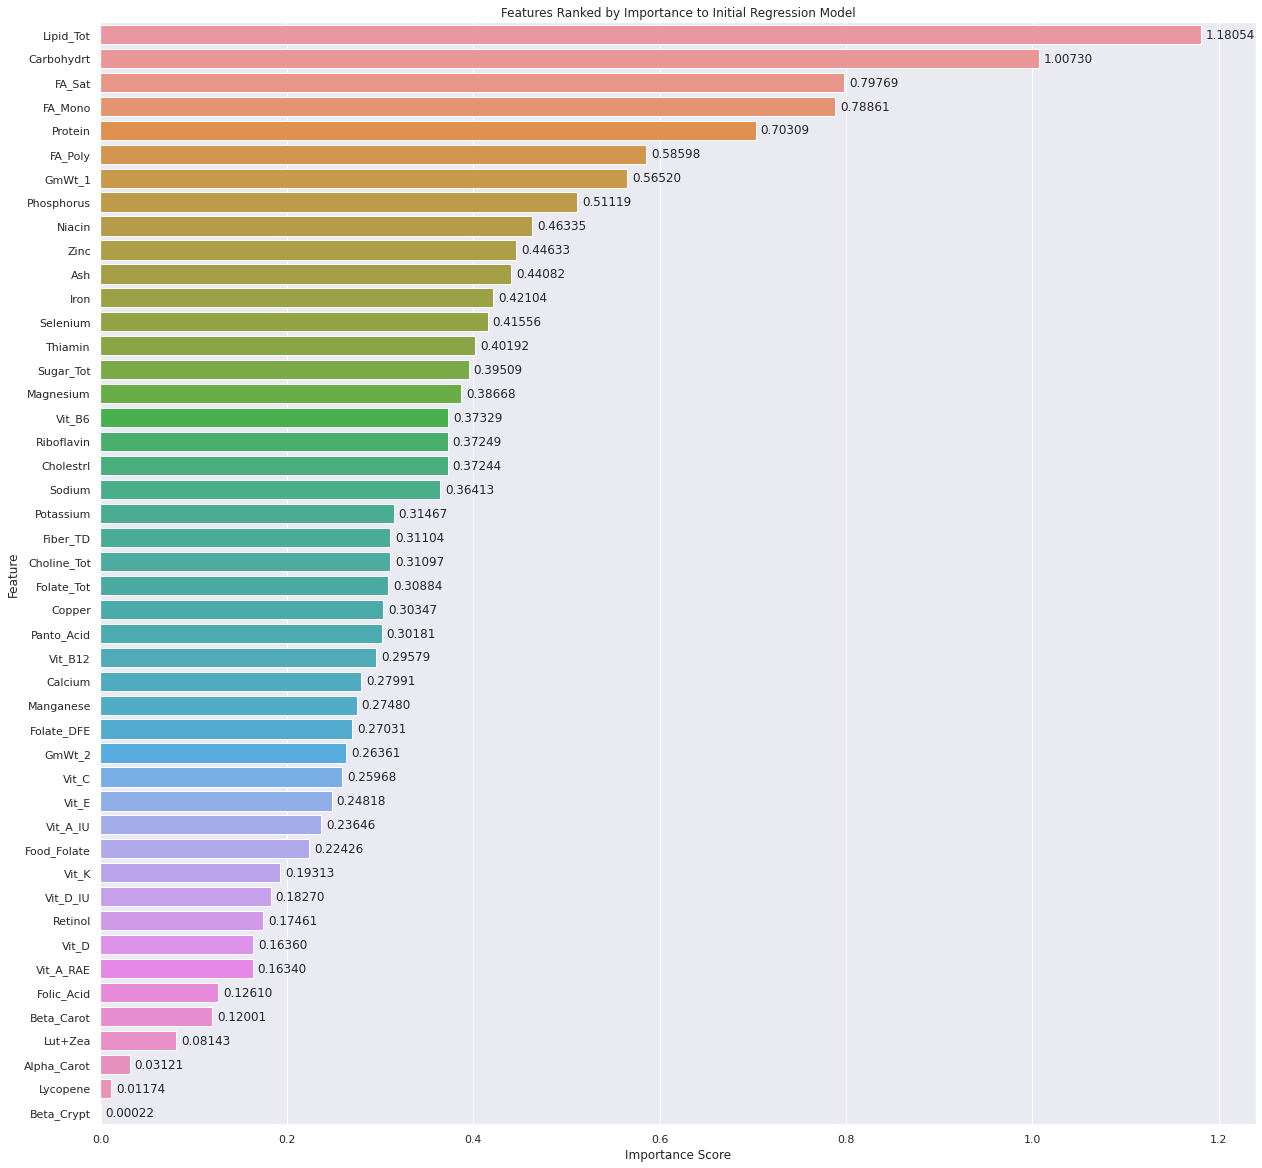

In [127]:
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

labels = [col for col in df_chosen_x]
importance = list(model.feature_importances_)

y_train = np.ravel(y_train)

fs = SelectKBest(score_func=mutual_info_regression, k='all')
fs.fit(X_train, y_train)

df_importance = pd.DataFrame({'labels': labels, 'importance': fs.scores_})
df_importance_sorted = df_importance.sort_values(by='importance', ascending=False)

ax=sns.barplot(x='importance', y='labels', data=df_importance_sorted, orient='h')
ax.bar_label(container=ax.containers[0], fmt='%1.5f', label_type='edge', padding=5)
sns.set(rc={'figure.figsize':(20.7, 20.27)})
plt.title('Features Ranked by Importance to Initial Regression Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Feature Engineering

In [142]:
split_desc = df['Shrt_Desc'].str.split(',')

category = []
for split in split_desc:
    category.append(split[0])

In [155]:
df['Desc_Cat'] = category
df['Desc_Cat'] = df['Desc_Cat'].astype("category")

In [166]:
split_water = df['Water'].str.split(' ')

water_g = []
for split in split_water:
    water_g.append(split[0])

water_g[1941]
# df['Water_Flt'] = water_g
# df['Water_Flt'] = df['Water_Flt'].astype('float')

''

In [167]:
df

,NDB_No,Shrt_Desc,Water,Energ_Kcal,Protein,Lipid_Tot,Ash,Carbohydrt,Fiber_TD,Sugar_Tot,...,FA_Mono,FA_Poly,Cholestrl,GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Desc_Cat,Water_Int,Water_Flt
0,1001,"BUTTER,WITH SALT",15.87 g,717,0.85,81.11,2.11,0.06,0.0,0.06,...,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,BUTTER,15.87,15.87
1,1002,"BUTTER,WHIPPED,W/ SALT",16.72 g,718,0.49,78.30,1.62,2.87,0.0,0.06,...,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,BUTTER,16.72,16.72
2,1003,"BUTTER OIL,ANHYDROUS",0.24 g,876,0.28,99.48,0.00,0.00,0.0,0.00,...,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup,BUTTER OIL,0.24,0.24
3,1004,"CHEESE,BLUE",42.41 g,353,21.40,28.74,5.11,2.34,0.0,0.50,...,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch,CHEESE,42.41,42.41
4,1005,"CHEESE,BRICK",41.11 g,371,23.24,29.68,3.18,2.79,0.0,0.51,...,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded",CHEESE,41.11,41.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8785,83110,"MACKEREL,SALTED",43 g,305,18.50,25.10,13.40,0.00,0.0,0.00,...,8.320,6.210,95.0,80.00,"1 piece, (5-1/2"" x 1-1/2"" x 1/2"")",17.0,"1 cubic inch, boneless",MACKEREL,43,43
8786,90240,"SCALLOP,(BAY&SEA),CKD,STMD",70.25 g,111,20.54,0.84,2.97,5.41,0.0,0.00,...,0.082,0.222,41.0,85.00,3 oz,NaN,NaN,SCALLOP,70.25,70.25
8787,90480,"SYRUP,CANE",26 g,269,0.00,0.00,0.86,73.14,0.0,73.20,...,0.000,0.000,0.0,21.00,1 serving,NaN,NaN,SYRUP,26,26
8788,90560,"SNAIL,RAW",79.2 g,90,16.10,1.40,1.30,2.00,0.0,0.00,...,0.259,0.252,50.0,85.00,3 oz,NaN,NaN,SNAIL,79.2,79.2


In [158]:
df['Water_Flt'].dtype

dtype('O')